In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.layers import Input, Dense, Conv1D, MaxPooling1D, UpSampling1D, BatchNormalization, LSTM, RepeatVector, Dropout
from tensorflow.keras.models import Sequential
from keras.models import Model
from keras.models import model_from_json
from keras import regularizers
import seaborn as sns
%matplotlib inline

In [2]:
tsmc_data = pd.read_csv('./Tsmc.csv', index_col = 'Date')
tsmc_data.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2007-01-02,66.987381,66.297806,66.790359,66.691849,26292533.0,37.779202
2007-01-03,67.676956,66.494827,66.790359,66.987381,42463339.0,37.946609
2007-01-04,67.085892,66.593338,66.691849,66.691849,22444226.0,37.779202
2007-01-05,66.691849,65.509720,66.494827,65.903763,30905222.0,37.332771
2007-01-08,65.509720,64.721634,65.115677,64.820145,24350615.0,36.718933


In [3]:
def build_stackautoencoder(input_shape, encode_shape_1, encode_shape_2, latent_shape):
    input_data = Input(shape = (1, input_shape))
    encode_1 = Dense(encode_shape_1, activation = 'relu', activity_regularizer=regularizers.l2(0))(input_data)
    encode_2 = Dense(encode_shape_2, activation = 'relu', activity_regularizer=regularizers.l2(0))(encode_1)
    encode_3 = Dense(latent_shape, activation = 'relu', activity_regularizer=regularizers.l2(0))(encode_2)

    decode_3 = Dense(encode_shape_2, activation = 'relu', activity_regularizer=regularizers.l2(0))(encode_3)
    decode_2 = Dense(encode_shape_1, activation = 'relu', activity_regularizer=regularizers.l2(0))(decode_3)
    decode_1 = Dense(input_shape, activation = 'sigmoid', activity_regularizer=regularizers.l2(0))(decode_2)

    # encode_1 = Dense(10, activation = 'relu', activity_regularizer=regularizers.l2(0))(input_data)
    # decode_1 = Dense(19, activation = 'sigmoid', activity_regularizer=regularizers.l2(0))(encode_1)


    autoencoder = Model(inputs = input_data, outputs = decode_1)
    encoder = Model(input_data, encode_3)

    autoencoder.compile(loss = 'mean_squared_error', optimizer = 'adam')
    autoencoder.summary()
    return autoencoder, encoder

In [4]:
def build_lstmmodel(input_shape):
    input_data = Input(shape = (1, input_shape))
    lstm1 = LSTM(50, return_sequences=True, activity_regularizer = regularizers.l2(0.001), recurrent_regularizer = regularizers.l2(0), dropout = 0.2, recurrent_dropout = 0.2)(input_data)
    perc = Dense(50, activity_regularizer=regularizers.l2(0.005))(lstm1)
    lstm2 = LSTM(50, activity_regularizer = regularizers.l2(0.001), recurrent_regularizer = regularizers.l2(0), dropout = 0.2, recurrent_dropout = 0.2)(perc)
    out = Dense(1, activity_regularizer=regularizers.l2(0.001))(lstm2)
    LSTMmodel = Model(input_data, out)
    LSTMmodel.compile(optimizer="adam", loss="mean_squared_error")
    LSTMmodel.summary()
    return LSTMmodel

In [5]:
tsmc_data = pd.read_csv('./Tsmc.csv', index_col = 'Date')
mask = tsmc_data['Volume'] != 0
tsmc_data = tsmc_data[mask]
tsmc_data['High_Low'] = tsmc_data['High'] - tsmc_data['Low']
tsmc_data['liq'] = tsmc_data['Close'] * tsmc_data['Volume']
tsmc_data['vol_return'] = np.log(tsmc_data['Volume']/ tsmc_data['Volume'].shift(1))
tsmc_data['day_return'] = np.log(tsmc_data['Close']/ tsmc_data['Close'].shift(1))
for i in range(2, 31, 2):
    tsmc_data[f'{i}day_ret'] = tsmc_data['day_return'] - tsmc_data['day_return'].shift(1)
    tsmc_data[f'{i}ma'] = tsmc_data['Close'].rolling(i).mean()
    tsmc_data[f'{i}ema'] = tsmc_data['Close'].ewm(span = i).mean()
    tsmc_data[f'{i}day_ret_ma'] = tsmc_data['day_return'].rolling(i).mean()
    tsmc_data[f'{i}day_ret_ema'] = tsmc_data['day_return'].ewm(span = i).mean()
    tsmc_data[f'{i}liq_ret'] = tsmc_data['liq']/ tsmc_data['liq'].shift(1)
tsmc_data['y_close'] = tsmc_data['Close'].shift(-1)
tsmc_data['y_ret'] = tsmc_data['day_return'].shift(-1)
tsmc_data.dropna(inplace = True)
tsmc_data.drop(columns = ['High', 'Low', 'Open', 'Adj Close'], inplace = True)
tsmc_data = tsmc_data.iloc[-1000:, :]

train_scaler = MinMaxScaler(feature_range = (-1, 1))
train_x = tsmc_data.iloc[:int(tsmc_data.shape[0]* 0.8), :-2]
train_x = train_scaler.fit_transform(train_x.values).reshape(train_x.shape[0], 1, train_x.shape[1])
test_x = tsmc_data.iloc[int(tsmc_data.shape[0]* 0.8):, :-2]
test_x = train_scaler.transform(test_x.values).reshape(test_x.shape[0], 1, test_x.shape[1])

#close
close_scaler = MinMaxScaler(feature_range = (-1, 1))
train_y_close = tsmc_data.iloc[:int(tsmc_data.shape[0]* 0.8), -2].values.reshape(-1, 1)
train_y_close = close_scaler.fit_transform(train_y_close)
test_y_close = tsmc_data.iloc[int(tsmc_data.shape[0]* 0.8):, -2].values.reshape(-1, 1)
test_y_close = close_scaler.transform(test_y_close)

#ret
# ret_scaler = MinMaxScaler(feature_range = (0, 1))
train_y_ret = tsmc_data.iloc[:int(tsmc_data.shape[0]* 0.8), -1].values.reshape(-1, 1)
# train_y_ret = ret_scaler.fit_transform(train_y_close)
test_y_ret = tsmc_data.iloc[int(tsmc_data.shape[0]* 0.8):, -1].values.reshape(-1, 1)
# test_y_ret = ret_scaler.transform(test_y_ret)

print('x:', train_x.shape, '\n', test_x.shape)
print('close:', train_y_close.shape, '\n', test_y_close.shape)
print('ret:', train_y_ret.shape, '\n', test_y_ret.shape)

x: (800, 1, 96) 
 (200, 1, 96)
close: (800, 1) 
 (200, 1)
ret: (800, 1) 
 (200, 1)


In [6]:
def Naive_backtesting(y_true, y_predict):
    data = {'True': y_true.reshape(-1), 'Predict': y_predict.reshape(-1)}
    tmp = pd.DataFrame(data = data)
    tmp['act'] = 0
    tmp.iloc[0, 2] = 'hold'
    for i in range(1, tmp.shape[0]):
        if (tmp.iloc[i, 1] > tmp.iloc[i - 1, 0]):
            tmp.iloc[i, 2] = 'buy'
            # print('buy  ', tmp.iloc[i - 1, 2])
        elif (tmp.iloc[i, 1] < tmp.iloc[i - 1, 0]):
            tmp.iloc[i, 2] = 'sell'
            # print('sell  ', tmp.iloc[i - 1, 2])
        else:
            tmp.iloc[i, 2] = 'hold'
            # print('hold')

    prv = 0
    idx = 0
    for i in range(1, tmp.shape[0]):
        idx = tmp.iloc[i, 2]
        if idx == 'buy':
            if prv == 'buy':
                tmp.iloc[i, 2] = 'hold'
            else:
                prv = 'buy'
        elif idx == 'sell':
            if prv == 'sell':
                tmp.iloc[i, 2] = 'hold'
            else:
                prv = 'sell'
        else:
            continue

    money = 100
    profit = 0
    loss = 0
    buy_price = 0
    flag = False
    count = 0
    for i in range(tmp.shape[0]):
        if tmp.iloc[i, 2] == 'buy':
            if flag == False:
                flag = True
                buy_price = tmp.iloc[i, 0]
        elif tmp.iloc[i, 2] == 'sell':
            if flag == True:
                flag = False
                count += 1
                revenue = (tmp.iloc[i, 0] - buy_price)/ buy_price
                if revenue > 0:
                    profit += revenue
                else :
                    loss += revenue
                money += revenue
    
    print(f'Number of Trading : {count}')
    print(f'Total Revenue : {money:.2f}')
    print(f'Profit Matrix : {profit/ abs(loss):.2f}')
    print(f'Max Dtawdown : {abs(loss):.2f}')

    buy = tmp['act'] == 'buy'
    sell = tmp['act'] == 'sell'
    plt.figure(figsize = (12, 8))
    plt.plot(tmp['True'], color = 'darkgrey')
    plt.scatter(x = tmp[buy].index, y = (tmp[buy])['True'].values, marker = '^', color = 'red')
    plt.scatter(x = tmp[sell].index, y = (tmp[sell])['True'].values, marker = 'v', color = 'green')

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1, 96)]           0         
                                                                 
 lstm (LSTM)                 (None, 1, 50)             29400     
                                                                 
 dense (Dense)               (None, 1, 50)             2550      
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 52,201
Trainable params: 52,201
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
25/25 [==============================] - 3s 2

Text(0.5, 1.0, 'LSTM with Close Price')

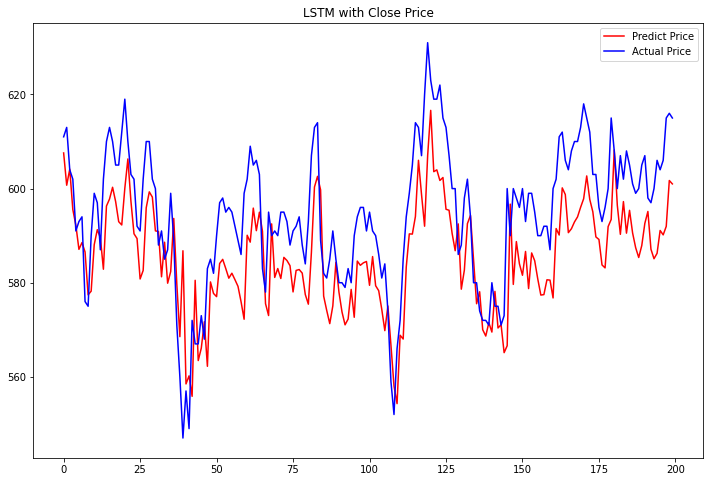

In [7]:
origin_lstm = build_lstmmodel(96)
origin_lstm.fit(train_x, train_y_close, epochs = 100)

y_predict = origin_lstm.predict(test_x)
y_predict_reverse = close_scaler.inverse_transform(y_predict)
y_true = close_scaler.inverse_transform(test_y_close)

plt.figure(figsize = (12, 8))
plt.plot(y_predict_reverse, color = 'r', label = 'Predict Price')
plt.plot(y_true, color = 'b', label = 'Actual Price')
plt.legend(loc = 'upper right')
plt.title('LSTM with Close Price')

Number of Trading : 3
Total Revenue : 100.11
Profit Matrix : inf
Max Dtawdown : 0.00


C:\Users\LEGION~1\AppData\Local\Temp/ipykernel_21184/2211016795.py:58: RuntimeWarning: divide by zero encountered in double_scalars
  print(f'Profit Matrix : {profit/ abs(loss):.2f}')


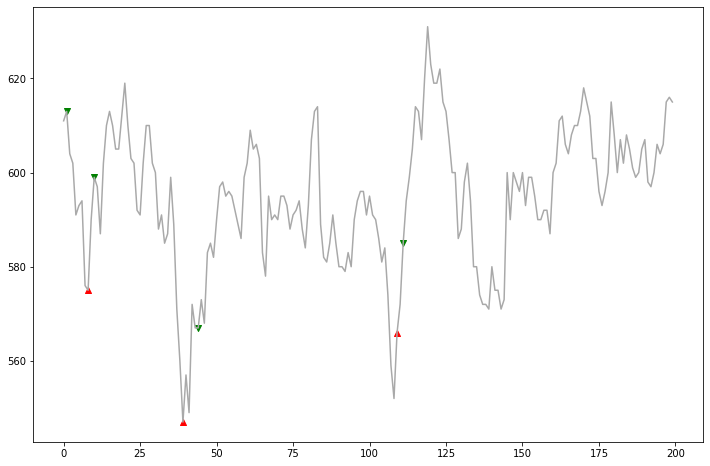

In [8]:
Naive_backtesting(y_true, y_predict_reverse)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1, 96)]           0         
                                                                 
 dense_2 (Dense)             (None, 1, 50)             4850      
                                                                 
 dense_3 (Dense)             (None, 1, 25)             1275      
                                                                 
 dense_4 (Dense)             (None, 1, 10)             260       
                                                                 
 dense_5 (Dense)             (None, 1, 25)             275       
                                                                 
 dense_6 (Dense)             (None, 1, 50)             1300      
                                                                 
 dense_7 (Dense)             (None, 1, 96)             4896

Text(0.5, 1.0, 'LSTM with Autoencoder')

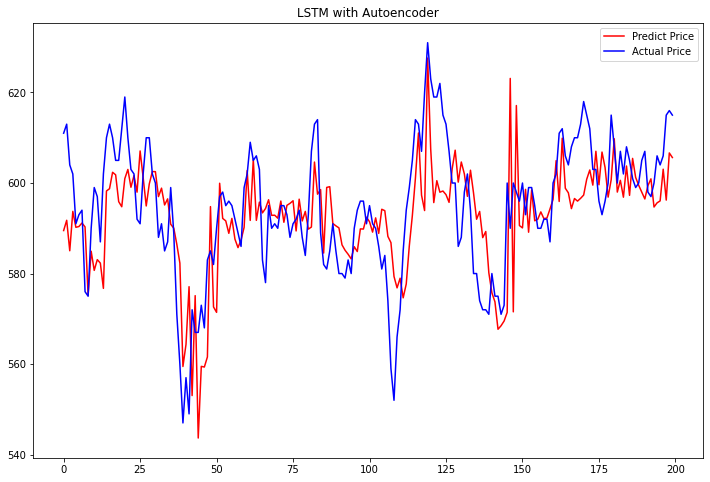

In [9]:
autoencoder, encoder = build_stackautoencoder(96, 50, 25, 10)
autoencoder.fit(train_x, train_x, epochs = 100)
encode_x = encoder.predict(train_x)
encode_test = encoder.predict(test_x)

aeLSTM = build_lstmmodel(10)
aeLSTM.fit(encode_x, train_y_close, epochs = 100)

y_predict = aeLSTM.predict(encode_test)
y_predict_reverse = close_scaler.inverse_transform(y_predict)
y_true = close_scaler.inverse_transform(test_y_close)

plt.figure(figsize = (12, 8))
plt.plot(y_predict_reverse, color = 'r', label = 'Predict Price')
plt.plot(y_true, color = 'b', label = 'Actual Price')
plt.legend(loc = 'upper right')
plt.title('LSTM with Autoencoder')

Number of Trading : 31
Total Revenue : 100.15
Profit Matrix : 1.98
Max Dtawdown : 0.15


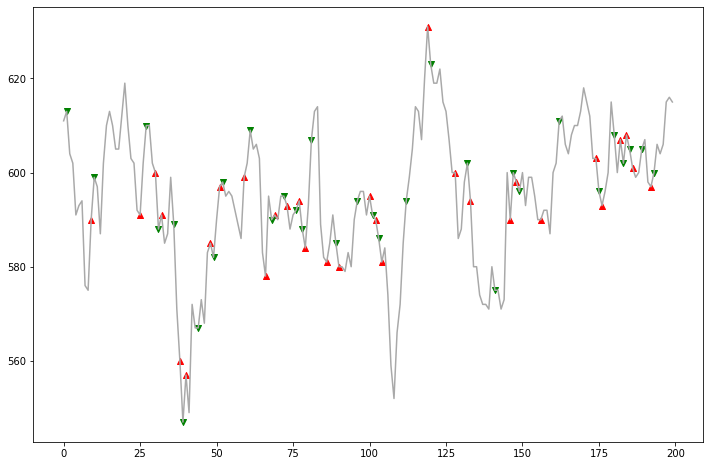

In [10]:
Naive_backtesting(y_true, y_predict_reverse)

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1, 96)]           0         
                                                                 
 lstm_4 (LSTM)               (None, 1, 50)             29400     
                                                                 
 dense_10 (Dense)            (None, 1, 50)             2550      
                                                                 
 lstm_5 (LSTM)               (None, 50)                20200     
                                                                 
 dense_11 (Dense)            (None, 1)                 51        
                                                                 
Total params: 52,201
Trainable params: 52,201
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
25/25 [==============================] - 2s

Text(0.5, 1.0, 'LSTM with Daily return')

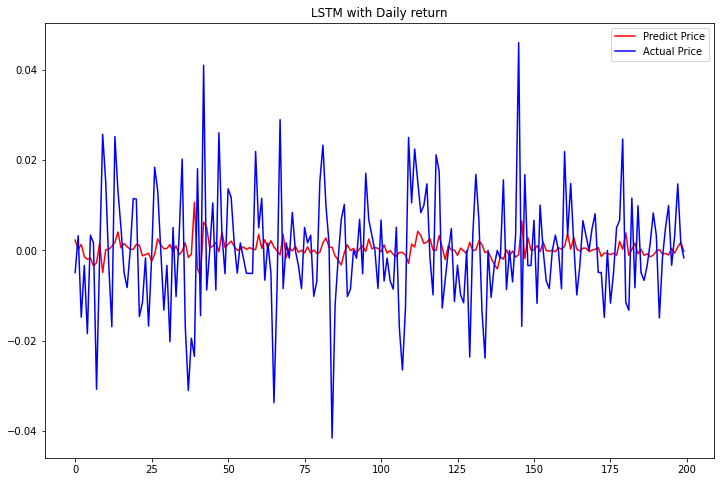

In [11]:
ret_LSTM = build_lstmmodel(96)
ret_LSTM.fit(train_x, train_y_ret, epochs = 100)

y_predict = ret_LSTM.predict(test_x)
y_true = test_y_ret

plt.figure(figsize = (12, 8))
plt.plot(y_predict, color = 'r', label = 'Predict Price')
plt.plot(y_true, color = 'b', label = 'Actual Price')
plt.legend(loc = 'upper right')
plt.title('LSTM with Daily return')

In [13]:
data = pd.read_csv('./Tsmc.csv', index_col = 'Date')
for i in range(1, 32, 10):
    data[f'{i}day_return'] = np.log(data['Close']/ data['Close'].shift(i))
data.dropna(inplace = True)
data.head()

,High,Low,Open,Close,Volume,Adj Close,1day_return,11day_return,21day_return,31day_return
Date,,,,,,,,,,
2007-02-14,66.297806,65.411209,66.002274,66.297806,3.610871e+07,37.555981,0.022540,-0.005365,-0.043612,-0.005926
2007-02-26,68.169510,67.676956,68.070999,67.873978,9.277150e+07,38.448849,0.023496,0.022011,-0.028614,0.013148
2007-02-27,69.056107,67.873978,67.972488,68.268021,7.743106e+07,38.672058,0.005789,0.033752,-0.022064,0.023359
2007-03-01,66.987381,65.706741,65.706741,65.706741,9.382418e+07,37.221165,-0.038240,-0.016357,-0.045429,-0.002994
2007-03-02,65.674232,64.987610,65.282158,65.478195,3.260939e+10,37.091694,-0.003484,-0.019842,-0.037386,0.010101


In [14]:
data.iloc[:, [-4,-2]].describe()

,1day_return,21day_return
count,3656.000000,3656.000000
mean,0.000615,0.012589
std,0.016799,0.064232
min,-0.082464,-0.324842
25%,-0.008608,-0.022219
50%,0.000000,0.014528
75%,0.009642,0.051076
max,0.095075,0.332343


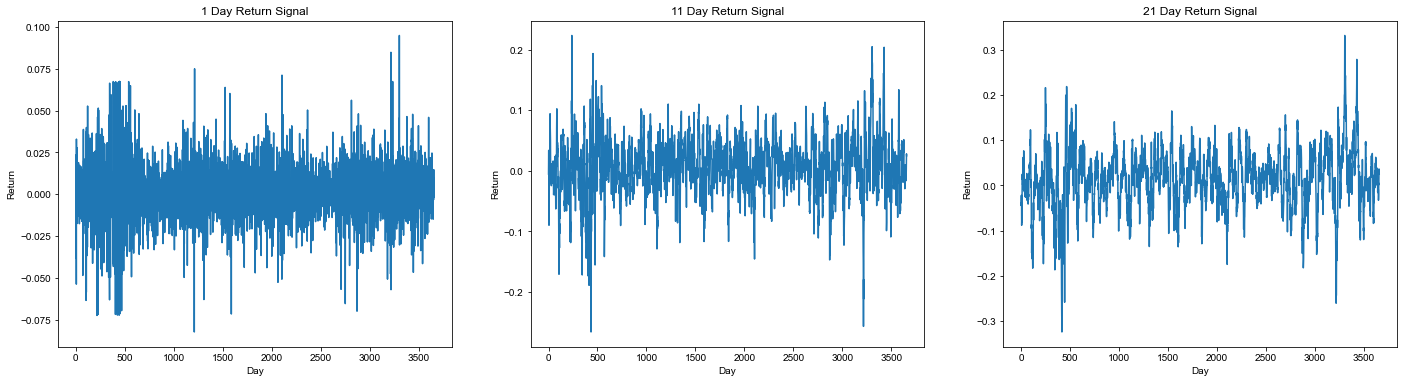

In [15]:
plt.figure(figsize = (24, 6)).subplots(1, 3)

plt.subplot(1, 3, 1)
plt.title(f'1 Day Return Signal')
plt.xlabel('Day')
plt.ylabel('Return')
plt.plot(data[f'1day_return'].values)

plt.subplot(1, 3, 2)
plt.title(f'11 Day Return Signal')
plt.xlabel('Day')
plt.ylabel('Return')
plt.plot(data[f'11day_return'].values)

plt.subplot(1, 3, 3)
plt.title(f'21 Day Return Signal')
plt.xlabel('Day')
plt.ylabel('Return')
plt.plot(data[f'21day_return'].values)

sns.set(font_scale=1.3)
sns.set_style({'font.family':'serif', 'font.serif':['Times New Roman']})

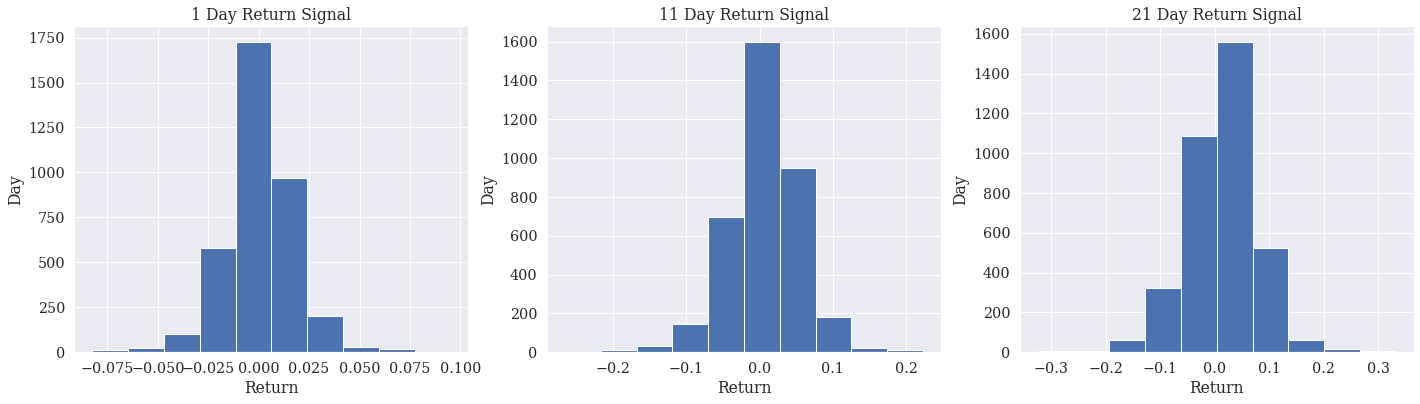

In [16]:
plt.figure(figsize = (24, 6)).subplots(1, 3)

plt.subplot(1, 3, 1)
plt.title(f'1 Day Return Signal')
plt.xlabel('Return')
plt.ylabel('Day')
plt.hist(data[f'1day_return'].values)

plt.subplot(1, 3, 2)
plt.title(f'11 Day Return Signal')
plt.xlabel('Return')
plt.ylabel('Day')
plt.hist(data[f'11day_return'].values)

plt.subplot(1, 3, 3)
plt.title(f'21 Day Return Signal')
plt.xlabel('Return')
plt.ylabel('Day')
plt.hist(data[f'21day_return'].values)

sns.set(font_scale=1.3)
sns.set_style({'font.family':'serif', 'font.serif':['Times New Roman']})

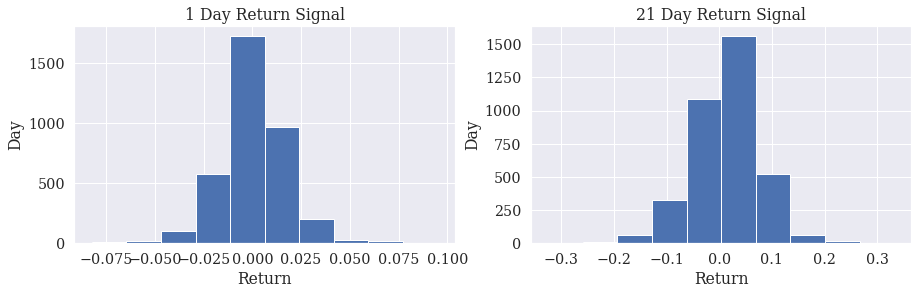

In [17]:
plt.figure(figsize = (15, 4)).subplots(1, 2)

plt.subplot(1, 2, 1)
plt.title(f'1 Day Return Signal')
plt.xlabel('Return')
plt.ylabel('Day')
plt.hist(data[f'1day_return'].values)



plt.subplot(1, 2, 2)
plt.title(f'21 Day Return Signal')
plt.xlabel('Return')
plt.ylabel('Day')
plt.hist(data[f'21day_return'].values)

sns.set(font_scale=1.3)
sns.set_style({'font.family':'serif', 'font.serif':['Times New Roman']})